# Nettoyage et préparation du dataset de lettrage bancaire

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import joblib 
import numpy as np

## Chargement des données
Les données sont chargées depuis un fichier CSV contenant des informations relatives à des opérations bancaires (dépenses et factures). Ces données serviront à l’analyse, à la détection de valeurs aberrantes, et à la création de nouvelles caractéristiques utiles pour le matching.


In [9]:
final_df = pd.read_csv("/kaggle/input/lettring-data/dataset_final.csv")

## Nettoyage initial

### Aperçu général
Un diagnostic est effectué pour visualiser :
- La forme du dataset (nombre de lignes et colonnes)
- La liste des colonnes
- Les types de données présents dans chaque colonne

### Valeurs manquantes
- Identification des colonnes contenant des valeurs manquantes
- Calcul du nombre et du pourcentage de valeurs manquantes pour chaque colonne

In [10]:
# Aperçu général
print("=== DIAGNOSTIC GÉNÉRAL ===")
print(f"Shape: {final_df.shape}")
print(f"Colonnes: {final_df.columns.tolist()}")
print(f"Types de données:")
print(final_df.dtypes)

# Valeurs manquantes
print("\n=== VALEURS MANQUANTES ===")
missing_values = final_df.isnull().sum()
missing_percent = (missing_values / len(final_df)) * 100
missing_df = pd.DataFrame({
    'Colonnes': missing_values.index,
    'Valeurs_manquantes': missing_values.values,
    'Pourcentage': missing_percent.values
})
print(missing_df[missing_df['Valeurs_manquantes'] > 0])

=== DIAGNOSTIC GÉNÉRAL ===
Shape: (27712, 23)
Colonnes: ['Unnamed: 0', 'id_releve', 'date_releve', 'libelle_operation', 'libelle_additionnel', 'debit', 'credit', 'date_valeur', 'etiquette', 'source_fusion', 'description', 'id_operation', 'date_operation', 'montant_operation', 'titre_operation', 'numero_reference', 'id_client', 'date_paiement', 'commentaires', 'statut', 'type_operation', 'categorie', 'montant_banque']
Types de données:
Unnamed: 0               int64
id_releve                int64
date_releve             object
libelle_operation       object
libelle_additionnel     object
debit                  float64
credit                 float64
date_valeur             object
etiquette                int64
source_fusion           object
description             object
id_operation             int64
date_operation          object
montant_operation      float64
titre_operation         object
numero_reference        object
id_client              float64
date_paiement           object
com


### Suppression des colonnes inutiles
Les colonnes jugées inutiles ou redondantes sont supprimées, notamment :
- Identifiants techniques (ex : id_client, id_operation)
- Colonnes de statut, fusion, source ou identifiant de relevé
- Informations de paiement déjà présentes ou non exploitables

### Traitement des valeurs manquantes restantes
- Les valeurs manquantes dans la colonne `categorie` sont remplacées par `"AUCUNE"`
- Les champs textuels (comme `commentaires`) sont remplis avec une chaîne vide

In [11]:
# Supprimer toutes les colonnes inutiles
final_df = final_df.drop(columns=['Unnamed: 0', 'debit', 'credit', 'id_client', 'date_paiement','source_fusion','id_releve','id_operation','statut','date_valeur'])

# Remplir les NaN restants
final_df['categorie'] = final_df['categorie'].fillna('DIVERS')  # Pour les invoices
final_df['commentaires'] = final_df['commentaires'].fillna('')  # Vide pour texte

print("Colonnes finales:", final_df.columns.tolist())
print("Vérification - NaN restants:", final_df.isnull().sum().sum())
print("Shape final:", final_df.shape)

Colonnes finales: ['date_releve', 'libelle_operation', 'libelle_additionnel', 'etiquette', 'description', 'date_operation', 'montant_operation', 'titre_operation', 'numero_reference', 'commentaires', 'type_operation', 'categorie', 'montant_banque']
Vérification - NaN restants: 0
Shape final: (27712, 13)


## Analyse des colonnes textuelles

### Séparation des types d’opérations
Le dataset est divisé en deux sous-ensembles :
- Les dépenses (`type_operation == 'depense'`)
- Les factures (`type_operation == 'facture'`)

### Exploration textuelle
Pour chaque type d’opération et pour chaque colonne textuelle :
- Quelques exemples de contenu sont affichés
- La longueur moyenne des textes est mesurée
- Le nombre de valeurs uniques est comptabilisé

In [12]:
# Séparer les deux types d'opérations
depenses_df = final_df[final_df['type_operation'] == 'depense'].copy()
factures_df = final_df[final_df['type_operation'] == 'facture'].copy()

print(f"DEPENSES: {len(depenses_df)} lignes")
print(f"FACTURES: {len(factures_df)} lignes")

# Colonnes texte à analyser
text_columns = ['libelle_operation', 'libelle_additionnel', 'description', 'titre_operation', 'commentaires']

print("\n" + "="*60)
print("ANALYSE DES DEPENSES")
print("="*60)

for col in text_columns:
    print(f"\n=== {col.upper()} - DEPENSES ===")
    print("Exemples:")
    print(depenses_df[col].dropna().head(5).tolist())
    print(f"Longueur moyenne: {depenses_df[col].str.len().mean():.1f}")
    print(f"Valeurs uniques: {depenses_df[col].nunique()}")

print("\n" + "="*60)
print("ANALYSE DES FACTURES")
print("="*60)

for col in text_columns:
    print(f"\n=== {col.upper()} - FACTURES ===")
    print("Exemples:")
    print(factures_df[col].dropna().head(5).tolist())
    print(f"Longueur moyenne: {factures_df[col].str.len().mean():.1f}")
    print(f"Valeurs uniques: {factures_df[col].nunique()}")

# Comparaison rapide
print("\n" + "="*60)
print("COMPARAISON RAPIDE")
print("="*60)
for col in text_columns:
    print(f"\n{col}:")
    print(f"  Depenses - Moy: {depenses_df[col].str.len().mean():.1f}, Uniques: {depenses_df[col].nunique()}")
    print(f"  Factures - Moy: {factures_df[col].str.len().mean():.1f}, Uniques: {factures_df[col].nunique()}")

DEPENSES: 14120 lignes
FACTURES: 13592 lignes

ANALYSE DES DEPENSES

=== LIBELLE_OPERATION - DEPENSES ===
Exemples:
['CARTE GROUPE Services Azure', 'CARTE GROUPE Services Azure', 'VIR GROUPE 5 ELEMENTS', 'VIR GROUPE 5 ELEMENTS', 'VIR GROUPE 5 ELEMENTS']
Longueur moyenne: 22.3
Valeurs uniques: 6284

=== LIBELLE_ADDITIONNEL - DEPENSES ===
Exemples:
['GROUPE REF: EXP202500010, EXP202500001', 'GROUPE REF: EXP202500010, EXP202500001', 'GROUPE REF: EXP202400002, EXP202500022, EXP202500156 +2 autres', 'GROUPE REF: EXP202400002, EXP202500022, EXP202500156 +2 autres', 'GROUPE REF: EXP202400002, EXP202500022, EXP202500156 +2 autres']
Longueur moyenne: 24.1
Valeurs uniques: 12434

=== DESCRIPTION - DEPENSES ===
Exemples:
['HÉBERGEMENT_CLOUD', 'SERVICES_UTILITAIRES', 'INVESTISSEMENT_INFRA', 'HÉBERGEMENT_CLOUD', 'LOGICIEL_RH']
Longueur moyenne: 14.9
Valeurs uniques: 31

=== TITRE_OPERATION - DEPENSES ===
Exemples:
['Services Azure', 'Téléphonie entreprise', 'Écran de travail', 'Cloudflare', 'Workda

In [13]:
import re

def preprocess_text(text) :
    # 1. Mettre en minuscules
    text = text.lower()
    # 2. Supprimer les caractères non imprimables
    text = re.sub(r"[^\x20-\x7E\u00C0-\u017F]", "", text)

    # 3. Normaliser les espaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [14]:
text_columns = ['libelle_operation', 'libelle_additionnel', 'description', 'titre_operation', 'commentaires']
for col in text_columns:
    final_df[col] = final_df[col].apply(preprocess_text)

In [15]:
final_df[final_df["type_operation"] == "depense"]

,date_releve,libelle_operation,libelle_additionnel,etiquette,description,date_operation,montant_operation,titre_operation,numero_reference,commentaires,type_operation,categorie,montant_banque
13592,2025-07-07,carte groupe services azure,"groupe ref: exp202500010, exp202500001",1,hébergement_cloud,2025-02-22,1136.81,services azure,EXP202500010,paiement groupé de 2 dépenses,depense,Services_Cloud,2182.74
13593,2025-07-07,carte groupe services azure,"groupe ref: exp202500010, exp202500001",1,services_utilitaires,2025-07-03,1045.93,téléphonie entreprise,EXP202500001,paiement groupé de 2 dépenses,depense,Services_Publiques,2182.74
13594,2025-04-02,vir groupe 5 elements,"groupe ref: exp202400002, exp202500022, exp202...",1,investissement_infra,2024-12-28,1370.98,écran de travail,EXP202400002,paiement groupé de 5 dépenses,depense,Équipement,9511.27
13595,2025-04-02,vir groupe 5 elements,"groupe ref: exp202400002, exp202500022, exp202...",1,hébergement_cloud,2025-02-16,1701.25,cloudflare,EXP202500022,paiement groupé de 5 dépenses,depense,Services_Cloud,9511.27
13596,2025-04-02,vir groupe 5 elements,"groupe ref: exp202400002, exp202500022, exp202...",1,logiciel_rh,2025-03-20,665.67,workday,EXP202500156,paiement groupé de 5 dépenses,depense,Outils_RH,9511.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27707,2024-12-04,carte partie frais tenue de compt 3,ref: exp202400073-p3 - partiel 3/5,1,frais_banque,2024-11-20,716.66,frais tenue de compte,EXP202400073,paiement partiel 3 de 5,depense,Frais_Bancaires,136.29
27708,2024-12-10,virement partiel exp202400073 4/5,ref: exp202400073-p4 - partiel 4/5,1,frais_banque,2024-11-20,716.66,frais tenue de compte,EXP202400073,paiement partiel 4 de 5,depense,Frais_Bancaires,98.55
27709,2024-12-09,paiement cb frais_bancaires partie 5,ref: exp202400073-p5 - partiel 5/5,1,frais_banque,2024-11-20,716.66,frais tenue de compte,EXP202400073,paiement partiel 5 de 5,depense,Frais_Bancaires,113.40
27710,2024-08-30,chèque n400020 partie 1,ref: exp202400020-p1 - partiel 1/2,1,avis_pro,2024-08-20,9463.26,audit technique,EXP202400020,paiement partiel 1 de 2,depense,Conseil,4697.00


In [16]:
abreviation_banquaire = {
    # Opérations courantes
    'vir': 'Virement',
    'prlv': 'Prélèvement', 
    'cb': 'Carte Bancaire',
    'dab': 'Distributeur Automatique de Billets',
    'gab': 'Guichet Automatique Bancaire',
    'tpe': 'Terminal de Paiement Électronique',
    'tip': 'Titre Interbancaire de Paiement',
    'lcr': 'Lettre de Change Relevé',
    'rib': 'Relevé d\'Identité Bancaire',
    
    # Codes internationaux
    'iban': 'International Bank Account Number',
    'bic': 'Bank Identifier Code',
    'swift': 'Society for Worldwide Interbank Financial Telecommunication',
    'sepa': 'Single Euro Payments Area',
    'ach': 'Automated Clearing House',
    'bban': 'Basic Bank Account Number',
    'mt103': 'Message Type 103',
    
    # Types de comptes
    'cc': 'Compte Courant',
    'cel': 'Compte Épargne Logement',
    'pel': 'Plan Épargne Logement',
    'lep': 'Livret d\'Épargne Populaire',
    'ldd': 'Livret de Développement Durable',
    'la': 'Livret A',
    'pea': 'Plan d\'Épargne en Actions',
    'av': 'Assurance Vie',
    
    # Frais et commissions
    'agios': 'Intérêts débiteurs',
    'com': 'Commission',
    'cotis': 'Cotisation',
    'abonnt': 'Abonnement',
    'frais': 'Frais bancaires',
    
    # Crédits et emprunts
    'cat': 'Crédit Amortissable Traditionnel',
    'pas': 'Prêt à l\'Accession Sociale',
    'ptz': 'Prêt à Taux Zéro',
    'taeg': 'Taux Annuel Effectif Global',
    'teg': 'Taux Effectif Global',
    
    # Moyens de paiement
    'cheq': 'Chèque',
    'especes': 'Espèces',
    'avis_ech': 'Avis d\'Échéance',
    
    # Organismes
    'bceao': 'Banque Centrale des États de l\'Afrique de l\'Ouest',
    'bam': 'Bank Al-Maghrib',
    'bce': 'Banque Centrale Européenne',
    'fmi': 'Fonds Monétaire International',
    'bri': 'Banque des Règlements Internationaux',
    'acpr': 'Autorité de Contrôle Prudentiel et de Résolution',
    
    # Termes comptables
    'debit': 'débit',
    'credit': 'crédit',
    'decouvert': 'découvert', 
    'provision': 'provision',
    'rapproch': 'rapprochement bancaire',
    'ref' : 'reference'
}

In [17]:
def correction_dabreviation(text):
    split = text.split()
    return " ".join([mot if not mot in abreviation_banquaire.keys() else abreviation_banquaire[mot].lower() for mot in split])
for col in text_columns:
    final_df[col] = final_df[col].apply(correction_dabreviation)

In [18]:
final_df[final_df["type_operation"] == "depense"]

,date_releve,libelle_operation,libelle_additionnel,etiquette,description,date_operation,montant_operation,titre_operation,numero_reference,commentaires,type_operation,categorie,montant_banque
13592,2025-07-07,carte groupe services azure,"groupe ref: exp202500010, exp202500001",1,hébergement_cloud,2025-02-22,1136.81,services azure,EXP202500010,paiement groupé de 2 dépenses,depense,Services_Cloud,2182.74
13593,2025-07-07,carte groupe services azure,"groupe ref: exp202500010, exp202500001",1,services_utilitaires,2025-07-03,1045.93,téléphonie entreprise,EXP202500001,paiement groupé de 2 dépenses,depense,Services_Publiques,2182.74
13594,2025-04-02,virement groupe 5 elements,"groupe ref: exp202400002, exp202500022, exp202...",1,investissement_infra,2024-12-28,1370.98,écran de travail,EXP202400002,paiement groupé de 5 dépenses,depense,Équipement,9511.27
13595,2025-04-02,virement groupe 5 elements,"groupe ref: exp202400002, exp202500022, exp202...",1,hébergement_cloud,2025-02-16,1701.25,cloudflare,EXP202500022,paiement groupé de 5 dépenses,depense,Services_Cloud,9511.27
13596,2025-04-02,virement groupe 5 elements,"groupe ref: exp202400002, exp202500022, exp202...",1,logiciel_rh,2025-03-20,665.67,workday,EXP202500156,paiement groupé de 5 dépenses,depense,Outils_RH,9511.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27707,2024-12-04,carte partie frais bancaires tenue de compt 3,ref: exp202400073-p3 - partiel 3/5,1,frais_banque,2024-11-20,716.66,frais bancaires tenue de compte,EXP202400073,paiement partiel 3 de 5,depense,Frais_Bancaires,136.29
27708,2024-12-10,virement partiel exp202400073 4/5,ref: exp202400073-p4 - partiel 4/5,1,frais_banque,2024-11-20,716.66,frais bancaires tenue de compte,EXP202400073,paiement partiel 4 de 5,depense,Frais_Bancaires,98.55
27709,2024-12-09,paiement carte bancaire frais_bancaires partie 5,ref: exp202400073-p5 - partiel 5/5,1,frais_banque,2024-11-20,716.66,frais bancaires tenue de compte,EXP202400073,paiement partiel 5 de 5,depense,Frais_Bancaires,113.40
27710,2024-08-30,chèque n400020 partie 1,ref: exp202400020-p1 - partiel 1/2,1,avis_pro,2024-08-20,9463.26,audit technique,EXP202400020,paiement partiel 1 de 2,depense,Conseil,4697.00


## les colones categoriele 

In [19]:
final_df["categorie"] = final_df["categorie"].apply(preprocess_text)

In [20]:
final_df["categorie"].value_counts()

categorie
divers                  13592
licences_logicielles     1442
juridique_conformité     1377
frais_bancaires          1328
outils_rh                1293
services_publiques       1271
équipement               1228
abonnements              1223
services_cloud           1203
assurances                867
formations                548
marketing                 543
divertissement            386
fournitures_bureau        364
maintenance               353
conseil                   350
déplacements              344
Name: count, dtype: int64

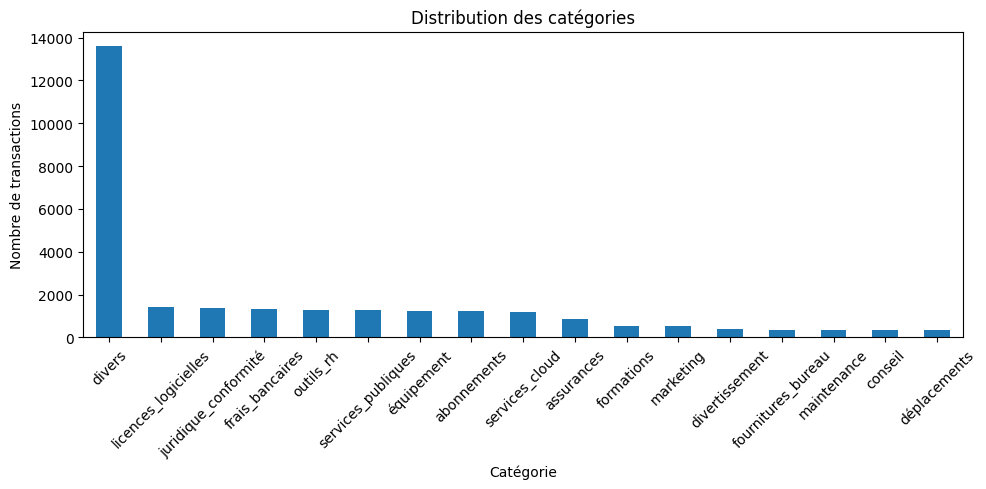

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Afficher les fréquences des catégories
final_df['categorie'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title("Distribution des catégories")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## traitemant des colones numerique `montant_banque`  `montant_operation`

In [22]:
numerique_columns = ["montant_banque","montant_operation"]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


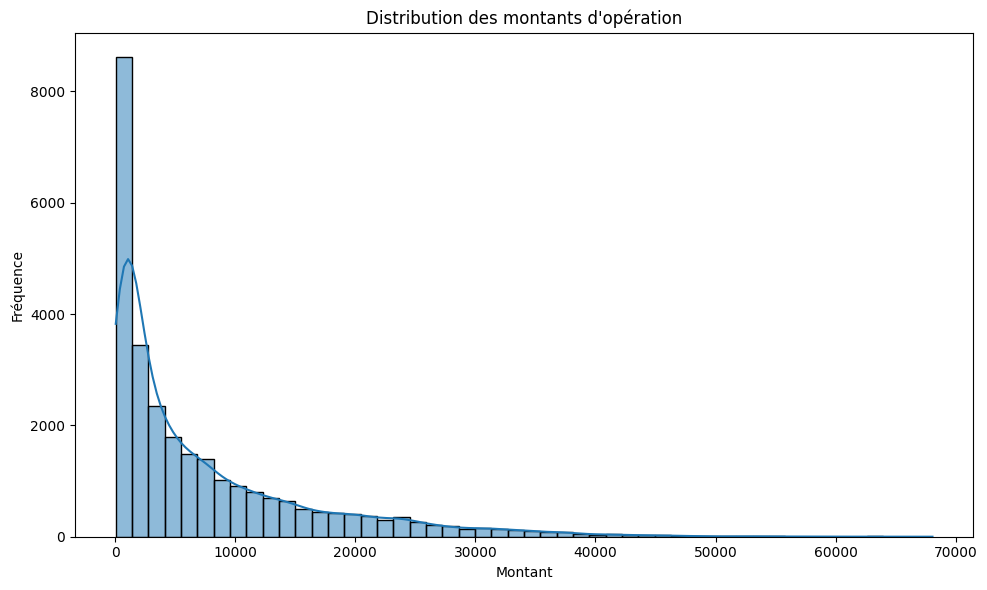

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(data=final_df, x='montant_operation', bins=50, kde=True)
plt.title("Distribution des montants d'opération")
plt.xlabel("Montant")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

### Suppression des outliers

Suppression des valeurs aberrantes (outliers) détectées dans chaque catégorie à l’aide de l’IQR.
markdown
Copier
Modifier


5.478331970564186 montant_banque
2.6528258362168398 montant_banque
4.857142857142857 montant_banque
1.4567392583872867 montant_banque
3.1088082901554404 montant_banque
3.77906976744186 montant_banque
4.562043795620438 montant_banque
4.1208791208791204 montant_banque
4.292168674698795 montant_banque
3.195352214960058 montant_banque
3.0513176144244105 montant_banque
3.6827195467422094 montant_banque
3.314917127071823 montant_banque
4.408352668213457 montant_banque
4.239401496259352 montant_banque
4.012588512981904 montant_banque
4.153094462540716 montant_banque


/tmp/ipykernel_36/107793009.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
2.0306062389640966 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation


/tmp/ipykernel_36/107793009.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


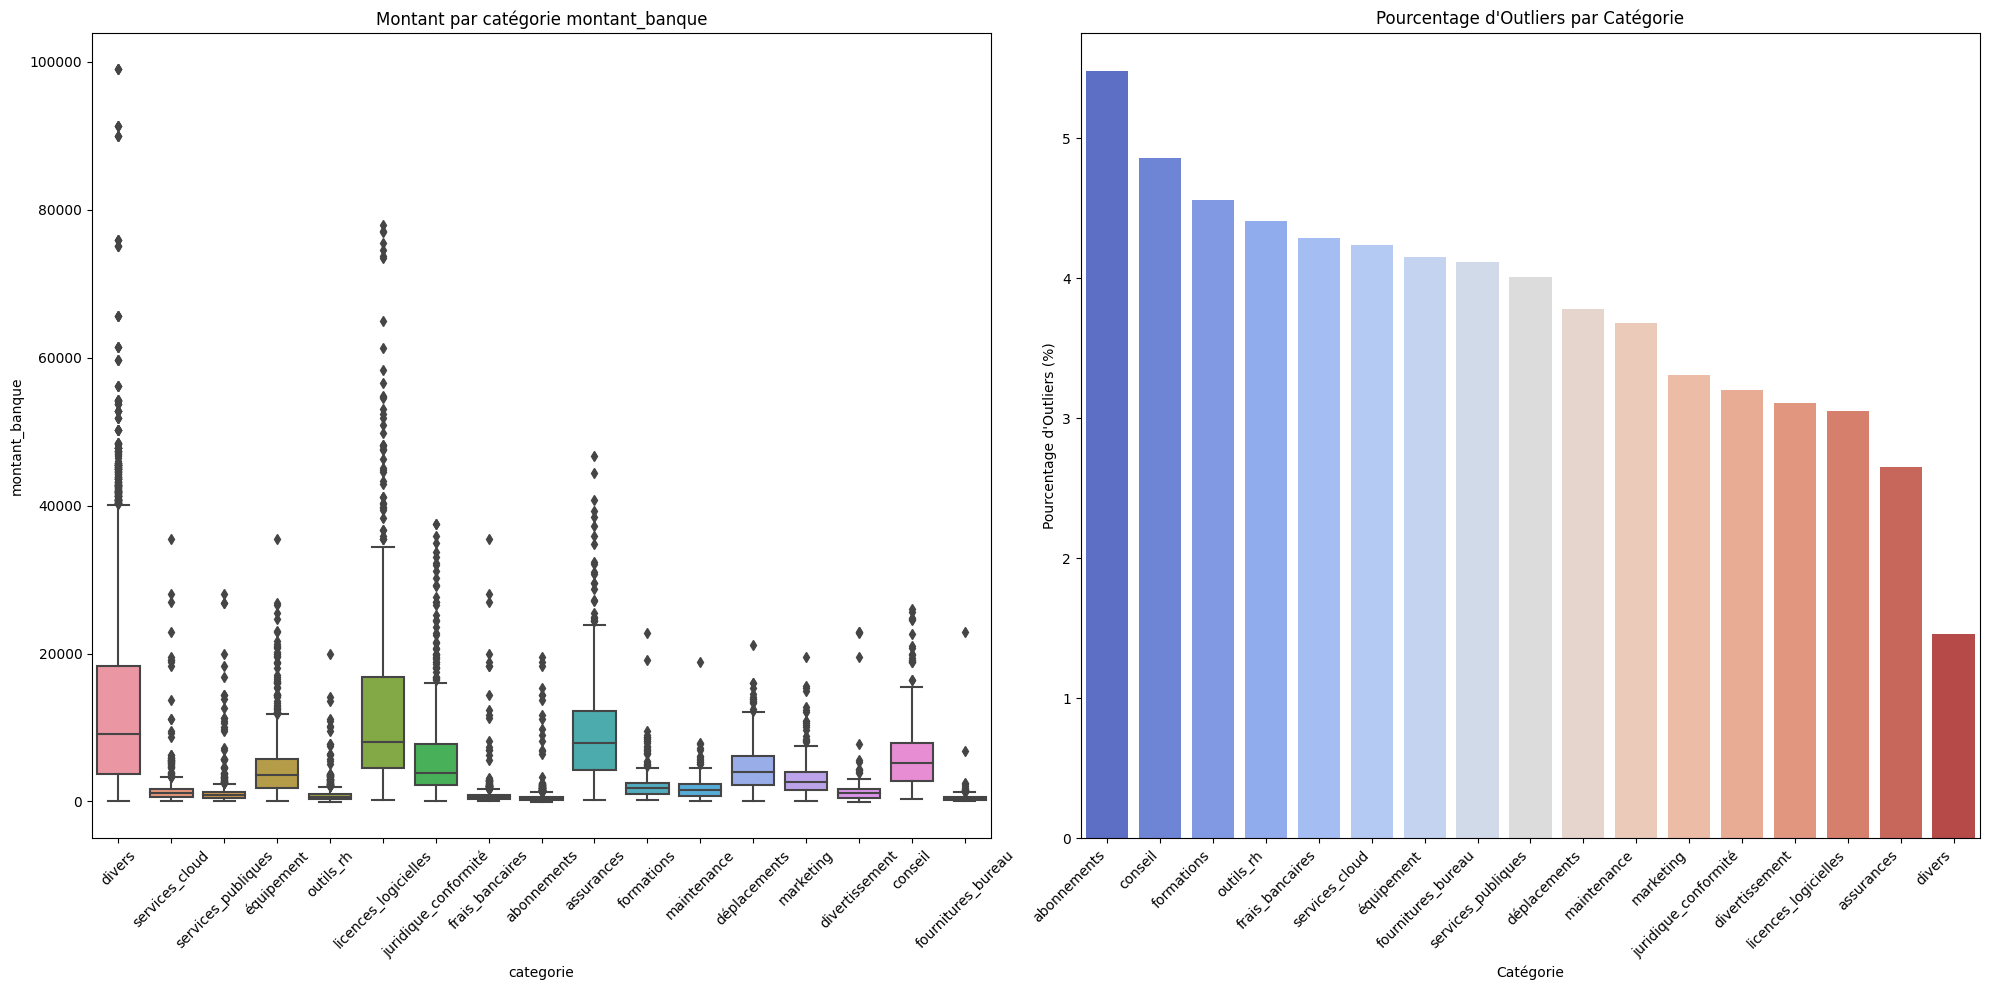

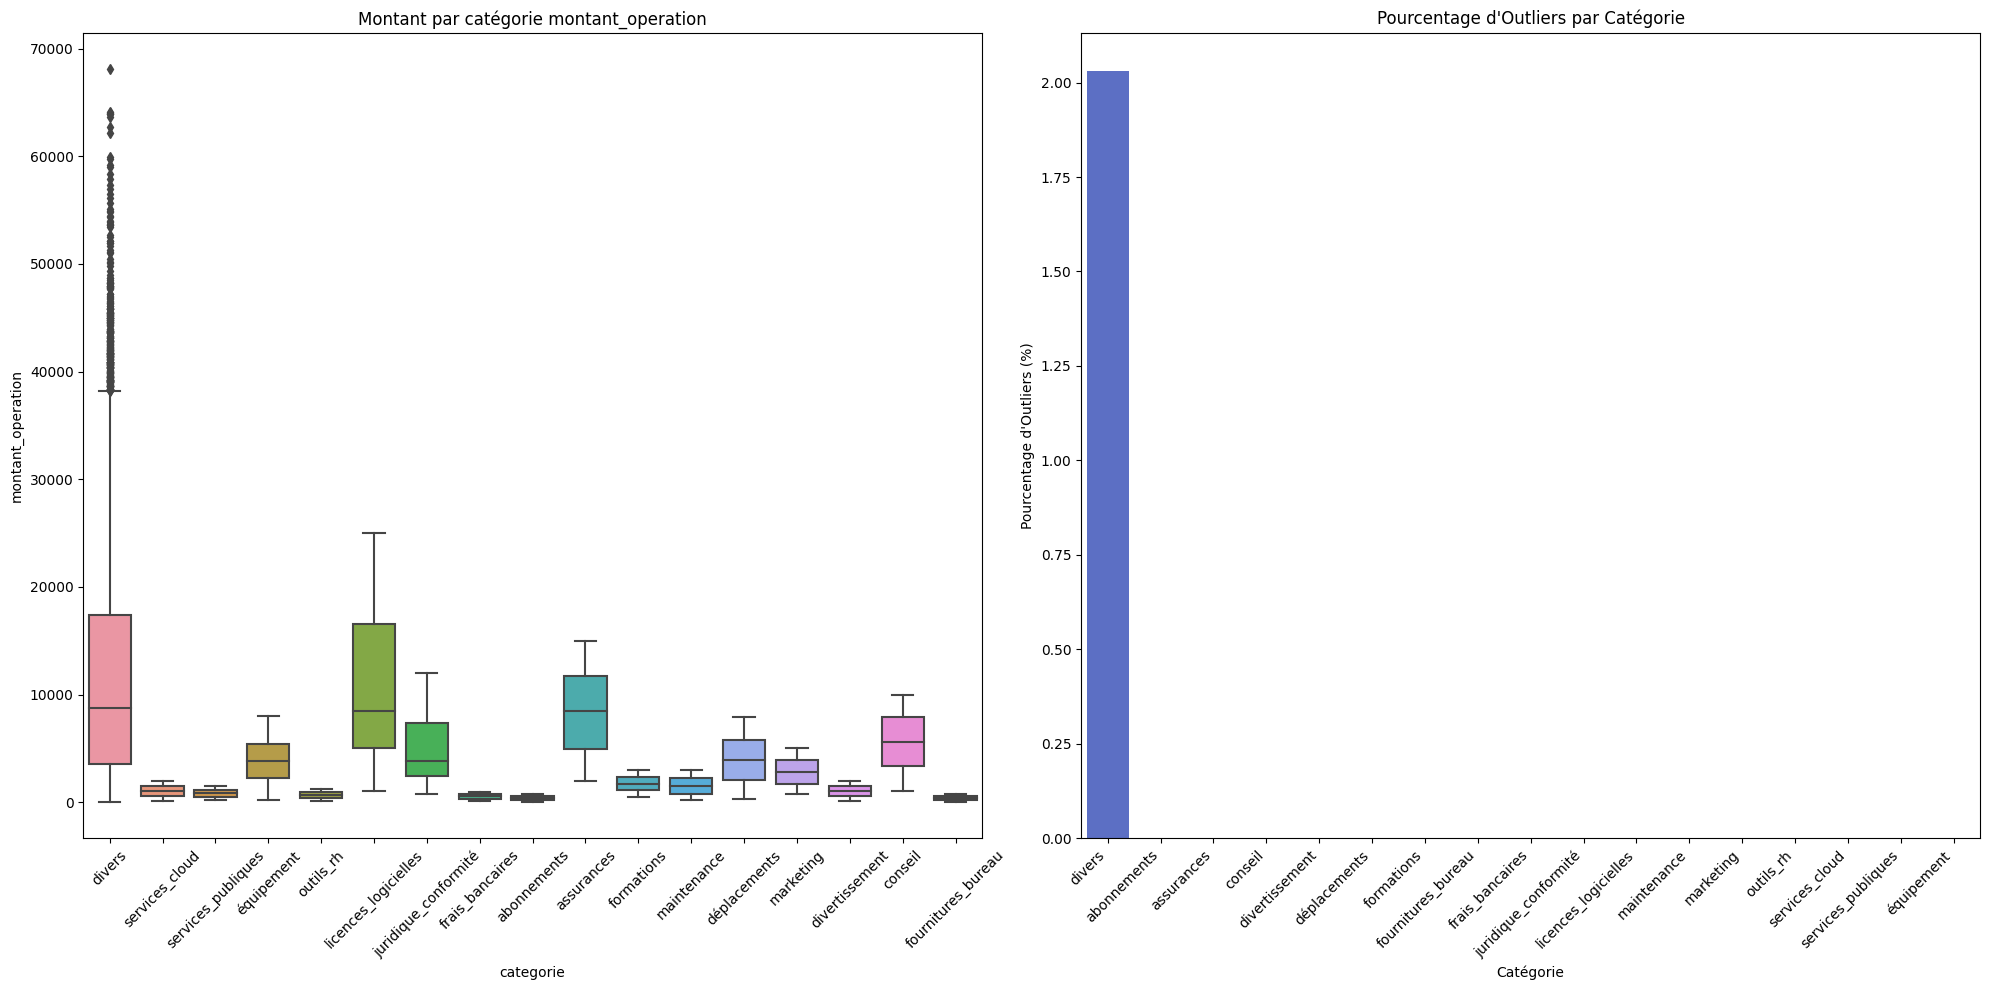

In [24]:

def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (series < lower) | (series > upper)

# Calcul du pourcentage d'outliers par catégorie
def get_outlier_percente(final_df,colone):
    outlier_stats = []

    for cat, group in final_df.groupby("categorie"):
        outliers = detect_outliers_iqr(group[colone])
        total = len(group)
        nb_outliers = outliers.sum()
        pct = (nb_outliers / total) * 100
        print(pct,col)
        outlier_stats.append({
            "categorie": cat,
            "pourcentage_outliers": round(pct, 2)
        })

    # Créer le DataFrame
    outliers_df = pd.DataFrame(outlier_stats)
    return outliers_df

# Trier pour plus de lisibilité
for col in numerique_columns:
    outliers_df = get_outlier_percente(final_df,col).sort_values(by="pourcentage_outliers", ascending=False)

    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.boxplot(data=final_df, x='categorie', y=col)
    plt.title(f"Montant par catégorie {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.subplot(1,2,2)
    sns.barplot(data=outliers_df, x="categorie", y="pourcentage_outliers", palette="coolwarm")
    plt.title("Pourcentage d'Outliers par Catégorie")
    plt.ylabel("Pourcentage d'Outliers (%)")
    plt.xlabel("Catégorie")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
plt.show()



In [25]:
def remove_outliers_iqr(df, column, group_by):
    df_cleaned = pd.DataFrame()

    # Pour chaque catégorie
    for cat, group in df.groupby(group_by):
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # On garde les valeurs dans l'intervalle
        group_cleaned = group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]
        df_cleaned = pd.concat([df_cleaned, group_cleaned])

    return df_cleaned
for col in numerique_columns :
    
 final_df = remove_outliers_iqr(final_df,col,'categorie')

0.7785467128027681 montant_banque
0.23696682464454977 montant_banque
1.2012012012012012 montant_banque
0.2885783718104496 montant_banque
0.0 montant_banque
0.6042296072507553 montant_banque
0.19120458891013384 montant_banque
0.5730659025787965 montant_banque
0.3933910306845004 montant_banque
0.3750937734433608 montant_banque
0.28612303290414876 montant_banque
0.0 montant_banque
0.7619047619047619 montant_banque
0.24271844660194172 montant_banque
0.4340277777777778 montant_banque
0.24590163934426232 montant_banque
0.33984706881903143 montant_banque


/tmp/ipykernel_36/520602939.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.6227217496962333 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation
0.0 montant_operation


/tmp/ipykernel_36/520602939.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


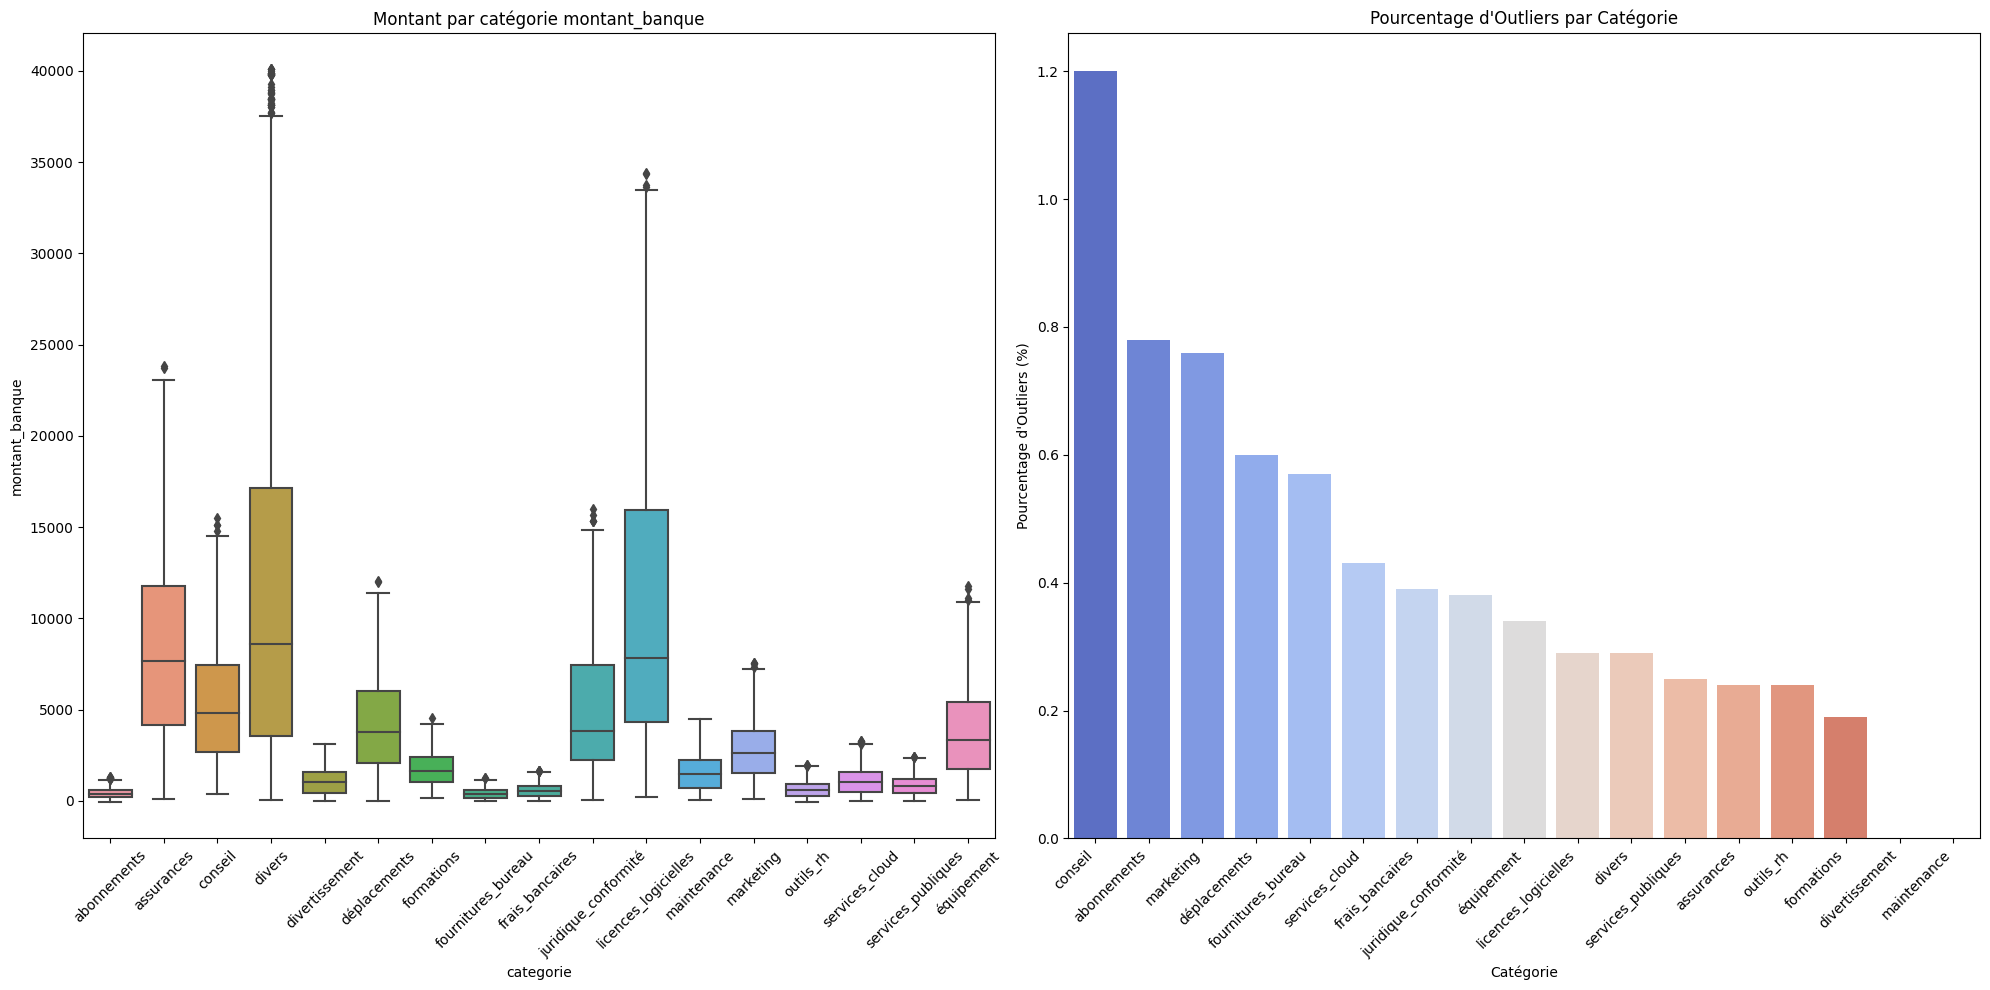

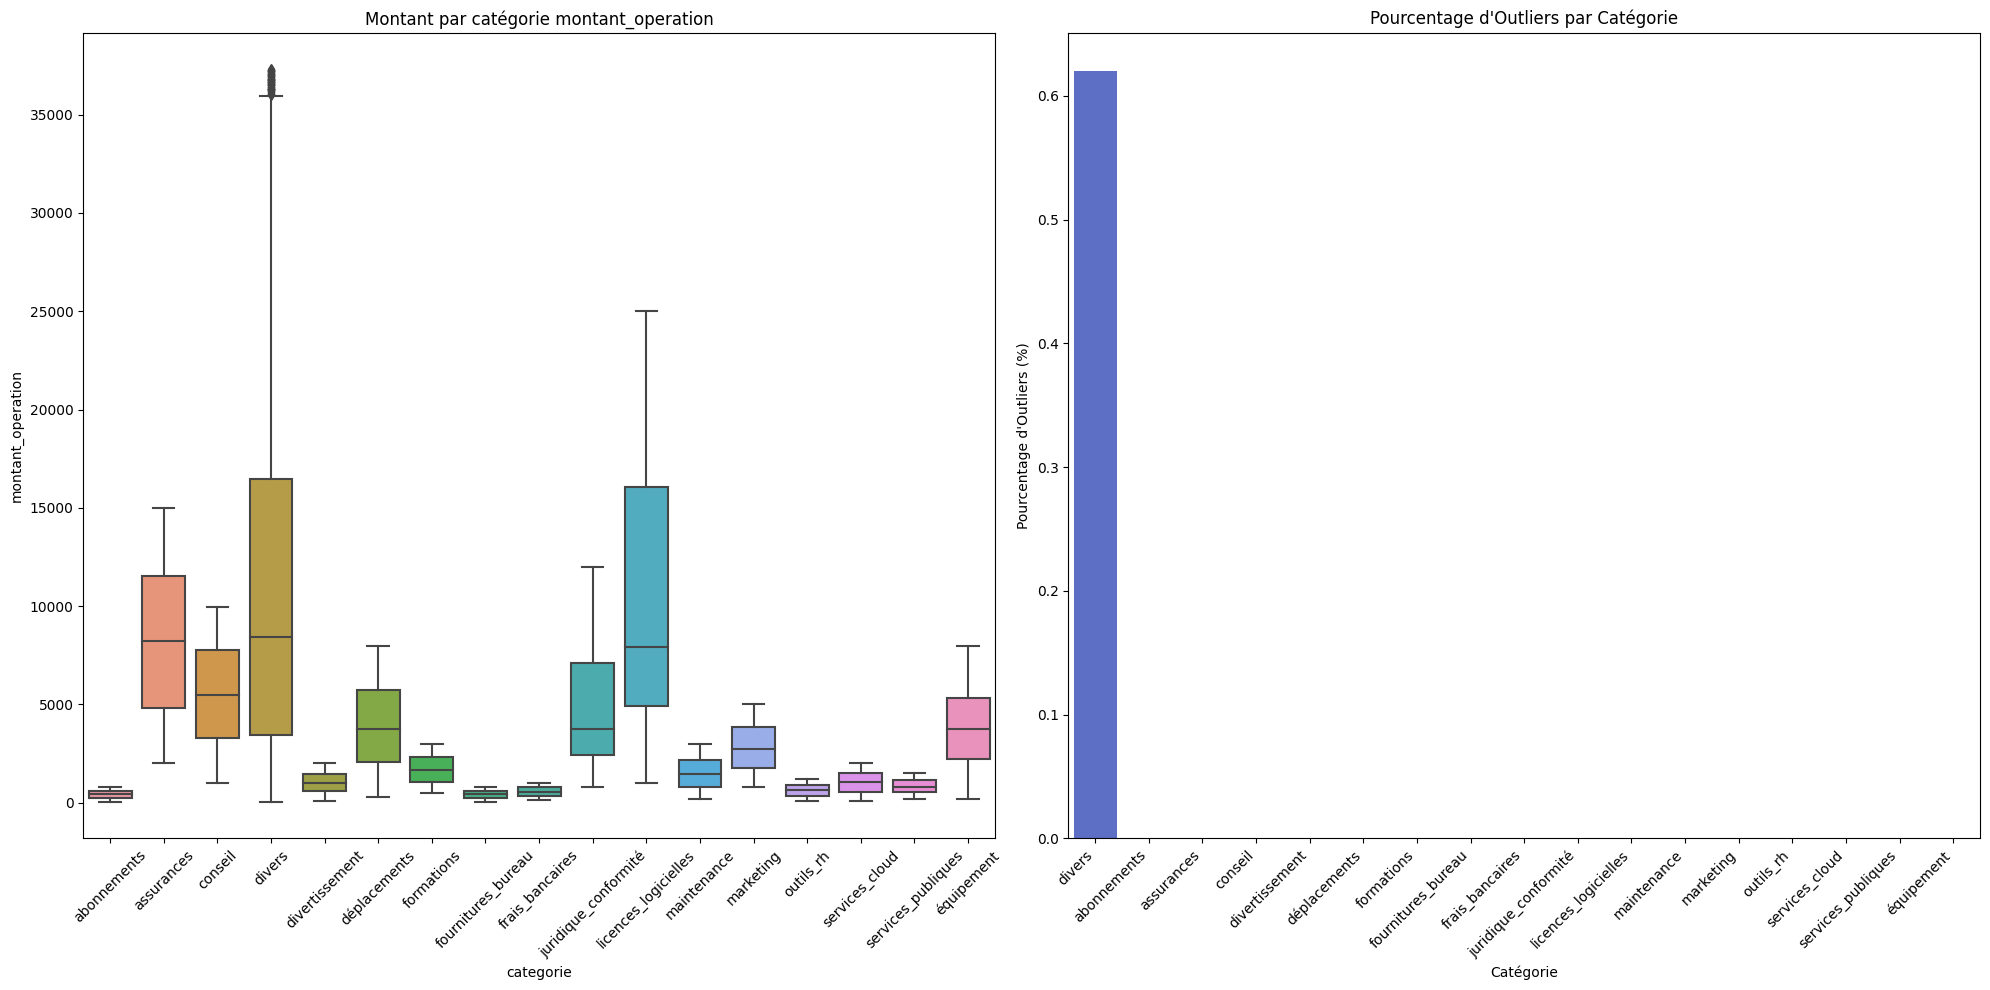

In [26]:
for col in numerique_columns:
    outliers_df = get_outlier_percente(final_df,col).sort_values(by="pourcentage_outliers", ascending=False)

    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    sns.boxplot(data=final_df, x='categorie', y=col)
    plt.title(f"Montant par catégorie {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.subplot(1,2,2)
    sns.barplot(data=outliers_df, x="categorie", y="pourcentage_outliers", palette="coolwarm")
    plt.title("Pourcentage d'Outliers par Catégorie")
    plt.ylabel("Pourcentage d'Outliers (%)")
    plt.xlabel("Catégorie")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
plt.show()



## Analyse de la corrélation entre montants

- Calcul de la corrélation entre `montant_banque` et `montant_operation`
- Analyse de la proportion des opérations lettrées où les montants sont identiques (`écart nul`)
- Visualisation du taux de correspondance exacte des montants par type d’opération

In [27]:
correlation = final_df[numerique_columns[0]].corr(final_df[numerique_columns[1]])
print(f"Corrélation entre montant_banque et montant_operation: {correlation}")


Corrélation entre montant_banque et montant_operation: 0.9316452780887302


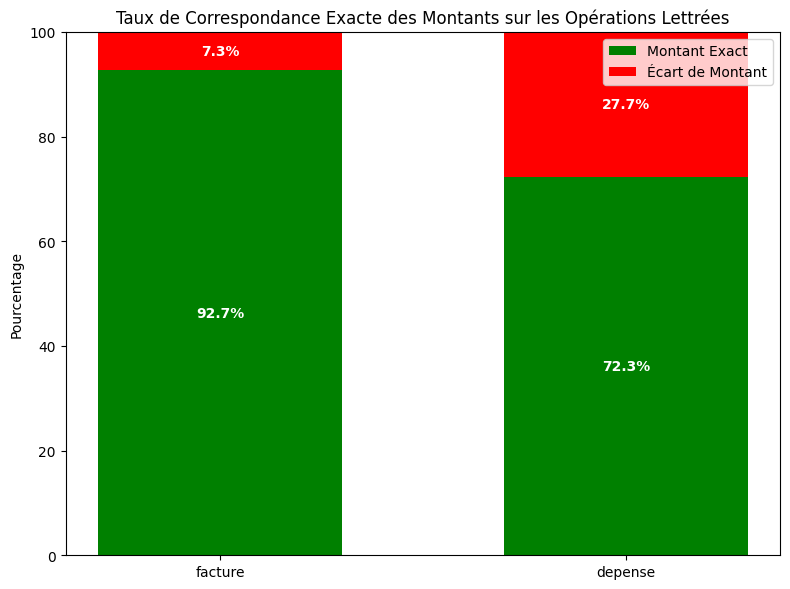

In [28]:
ecart_nul_facture = final_df[(final_df['etiquette'] == 1) & (final_df["montant_banque"] == final_df["montant_operation"]) & (final_df["type_operation"] == "facture")]["montant_banque"].count()/final_df[(final_df["etiquette"] == 1)  & (final_df["type_operation"] == "facture")].shape[0]*100
ecart_nul_depense = final_df[(final_df['etiquette'] == 1) & (final_df["montant_banque"] == final_df["montant_operation"]) & (final_df["type_operation"] == "depense")]["montant_banque"].count()/final_df[(final_df["etiquette"] == 1)  & (final_df["type_operation"] == "depense")].shape[0]*100
operations = ["facture","depense"]
equals = [ecart_nul_facture, ecart_nul_depense]
non_equals = [100 - ecart_nul_facture, 100 - ecart_nul_depense]
x = np.arange(len(operations))
width = 0.6

# Création du graphique
fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(x, equals, width, label='Montant Exact', color='green')
bar2 = ax.bar(x, non_equals, width, bottom=equals, label='Écart de Montant', color='red')

# Ajout des étiquettes de pourcentage sur les barres
for i in range(len(x)):
    ax.text(x[i], equals[i]/2, f"{equals[i]:.1f}%", ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    ax.text(x[i], equals[i] + non_equals[i]/2, f"{non_equals[i]:.1f}%", ha='center', va='center', color='white', fontsize=10, fontweight='bold')

# Personnalisation
ax.set_xticks(x)
ax.set_xticklabels(operations)
ax.set_ylim(0, 100)
ax.set_ylabel('Pourcentage')
ax.set_title("Taux de Correspondance Exacte des Montants sur les Opérations Lettrées")
ax.legend()

plt.tight_layout()
plt.show()



Traitement des données temporelles

- Conversion des colonnes `date_operation` et `date_releve` en format datetime
- Calcul du délai (en jours) entre les deux dates

In [29]:
date_columns = ['date_releve','date_operation']

In [30]:
for col in date_columns:
    print(final_df[col].dtypes) 

object
object


In [31]:
for col in date_columns:
 final_df[col] = pd.to_datetime(final_df[col], errors='coerce')
for col in date_columns:
    print(final_df[col].dtypes) 

datetime64[ns]
datetime64[ns]


In [32]:
print(final_df.shape)
final_df

(26730, 13)


,date_releve,libelle_operation,libelle_additionnel,etiquette,description,date_operation,montant_operation,titre_operation,numero_reference,commentaires,type_operation,categorie,montant_banque
13610,2024-08-31,prelevement auto services_cloud groupe,"groupe ref: exp202400172, exp202400152",1,outils_numériques,2024-08-26,448.85,zoom pro,EXP202400152,paiement groupé de 2 dépenses,depense,abonnements,988.89
13674,2025-05-31,paiement carte bancaire abonnements lot,"groupe ref: exp202500092, exp202500066",1,plateforme_saas,2025-03-27,186.47,github entreprise,EXP202500092,paiement groupé de 2 dépenses,depense,abonnements,685.81
13858,2024-12-14,paiement carte bancaire abonnements,ref: exp202403766 - mensuel,1,outils_numériques,2024-12-13,518.18,github entreprise,EXP202403766,paiement depense exp202403766,depense,abonnements,518.18
13863,2025-03-01,prélèvement auto abonnements,ref: exp202503364 - mensuel,1,outils_numériques,2025-03-01,534.96,slack premium,EXP202503364,paiement depense exp202503364,depense,abonnements,534.96
13869,2025-03-03,virement exp202501830,ref: exp202501830 - mensuel,1,outils_numériques,2025-03-01,524.38,adobe creative cloud,EXP202501830,paiement depense exp202501830,depense,abonnements,524.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27642,2024-11-15,transfert équipement partie 2,ref: exp202400196-p2 - partiel 2/2,1,investissement_infra,2024-11-02,5629.49,écran de travail,EXP202400196,paiement partiel 2 de 2,depense,équipement,4539.64
27643,2024-11-25,virement partiel exp202400068 1/2,ref: exp202400068-p1 - partiel 1/2,1,investissement_infra,2024-11-25,5201.08,chaise ergonomique,EXP202400068,paiement partiel 1 de 2,depense,équipement,712.56
27644,2024-12-13,virement partie exp202400068-2,ref: exp202400068-p2 - partiel 2/2,1,investissement_infra,2024-11-25,5201.08,chaise ergonomique,EXP202400068,paiement partiel 2 de 2,depense,équipement,4488.52
27695,2025-02-04,transfert équipement partie 1,ref: exp202500033-p1 - partiel 1/2,1,investissement_infra,2025-02-02,1765.32,matériel dimpression,EXP202500033,paiement partiel 1 de 2,depense,équipement,929.60


In [33]:
final_df.describe()

,date_releve,etiquette,date_operation,montant_operation,montant_banque
count,26730,26730.000000,26730,26730.000000,26730.000000
mean,2024-12-02 03:54:01.212121088,0.537598,2024-10-31 11:06:33.535353344,7019.308054,7140.222906
min,2023-08-20 00:00:00,0.000000,2023-07-31 00:00:00,50.060000,-43.530000
25%,2024-08-08 00:00:00,0.000000,2024-07-31 00:00:00,1034.640000,1020.310000
50%,2024-12-20 00:00:00,1.000000,2024-12-01 00:00:00,3726.430000,3668.935000
75%,2025-05-01 18:00:00,1.000000,2025-04-02 00:00:00,10218.027500,10569.137500
max,2026-05-12 00:00:00,1.000000,2025-07-30 00:00:00,37296.500000,40080.690000
std,NaN,0.498594,NaN,8038.280098,8265.110992


## feature Engineering 

In [34]:
final_df.columns

Index(['date_releve', 'libelle_operation', 'libelle_additionnel', 'etiquette',
       'description', 'date_operation', 'montant_operation', 'titre_operation',
       'numero_reference', 'commentaires', 'type_operation', 'categorie',
       'montant_banque'],
      dtype='object')

Création automatique de plusieurs types de variables pour le modèle de matching :

- **Features textuelles** : similarité cosinus entre textes bancaires et internes
- **Features temporelles** : délai entre date relevé et opération
- **Features numériques** : ratio et écart des montants
- **Features catégorielles** : one-hot encoding de `type_operation` et `categorie`

Un pipeline simple est implémenté pour encapsuler tout ce processus.

In [ ]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
class FeatureExtractionPipeline:
    def __init__(self):
        print("Initialisation du pipeline simplifié...")
        self.sentence_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
        self.ohe_encoders = {}

    def prepare_text_columns(self, df):
        print("Nettoyage des textes...")

        cols_tx = ['libelle_operation', 'libelle_additionnel', 'commentaires']
        cols_op = ['titre_operation', 'description', 'numero_reference']

    # Concaténation vectorisée avec agg + ' '.join
        df['texte_transaction'] = df[cols_tx].agg(' '.join, axis=1)
        df['texte_operation'] = df[cols_op].agg(' '.join, axis=1)
        return df

    def create_text_features(self, df):
        print("Création des features textuelles...")
        tx_texts = df['texte_transaction'].tolist()
        op_texts = df['texte_operation'].tolist()

        emb_tx = self.sentence_model.encode(tx_texts, show_progress_bar=True)
        emb_op = self.sentence_model.encode(op_texts, show_progress_bar=True)

        similarities = []
      
        for i in range(len(emb_tx)):
            sim = cosine_similarity([emb_tx[i]], [emb_op[i]])[0][0]
            similarities.append(sim)
        df['presence_num_ref'] = df.apply(
    lambda row: str(row['numero_reference']).lower() in str(row['texte_transaction']).lower(),
    axis=1
)

        feats = pd.DataFrame()
        feats['similarite_cos'] = similarities
        return feats

    def create_temporal_features(self, df):
     print("Création des features temporelles...")

     delais = (df['date_releve'] - df['date_operation']).dt.days
     type_ops = df['type_operation'].fillna('').str.lower()

     fenetre_valide = (
        ((type_ops == 'facture') & (delais.abs() <= 60)) |
        ((type_ops == 'depense') & (True))
    )

     feats = pd.DataFrame({
        'delai_jours': delais,
        'delai_absolu': delais.abs(),
        'dans_fenetre_valide': fenetre_valide
    })

     return feats

    def create_numerical_features(self, df):
        print("Création des features numériques...")
        feats = pd.DataFrame(index=df.index)
        feats['montant_ratio'] = df['montant_operation']/df['montant_banque']

        if 'montant_banque' in df.columns:
            ecart = abs(df['montant_operation'] - df['montant_banque'])
            feats['ecart_montant'] = ecart
            feats['montant_exact_match'] = ecart == 0
        return feats

    def create_categorical_features(self, df):
     print("🏷 Création des features catégorielles...")
     feats = pd.DataFrame(index=df.index)
     ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
     for col in ['type_operation', 'categorie']:
        if col in df.columns:
            filled = df[col].astype(str).values.reshape(-1,1)
            encoded = ohe.fit_transform(filled)
            joblib.dump(ohe,f"{col}_encoder.pkl")
            # noms des colonnes
            categories = ohe.categories_[0]
            col_names = [f"{col}_{cat}" for cat in categories]
            df_ohe = pd.DataFrame(encoded, columns=col_names, index=df.index)
            feats = pd.concat([feats, df_ohe], axis=1)
            self.ohe_encoders[col] = ohe  # pour garder l’encodeur si besoin
     return feats

    def run(self, df):
        print("Exécution du pipeline...")
        df = df.reset_index(drop=True)
        df = self.prepare_text_columns(df)
        print(df.shape)
        text_feats = self.create_text_features(df)
        print(len(text_feats))
        temporal_feats = self.create_temporal_features(df)
        print(len(temporal_feats))
        
        numerical_feats = self.create_numerical_features(df)
        print(len(numerical_feats))
        categorical_feats = self.create_categorical_features(df)
        print(len(numerical_feats))
        all_feats = pd.concat([text_feats, temporal_feats, numerical_feats, categorical_feats], axis=1)
        print(len(all_feats))
        return pd.concat([df, all_feats], axis=1)


2025-08-19 18:21:12.507213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755627672.688270      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755627672.741110      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
if __name__ == "__main__":
    pipeline = FeatureExtractionPipeline()
    df_features = pipeline.run(final_df)
    (df_features.head())
    df_features = df_features.drop(columns=['libelle_operation','texte_operation' ,'texte_transaction','libelle_additionnel', 'commentaires',
                    'titre_operation', 'description', 'numero_reference','type_operation', 'categorie', 'date_releve', 'date_operation'])
    df_features.to_csv("df_features.csv")


Initialisation du pipeline simplifié...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Exécution du pipeline...
Nettoyage des textes...
(26730, 15)
Création des features textuelles...


Batches:   0%|          | 0/836 [00:00<?, ?it/s]

Batches:   0%|          | 0/836 [00:00<?, ?it/s]

26730
Création des features temporelles...
26730
Création des features numériques...
26730
🏷 Création des features catégorielles...
26730
26730


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
(df_features.shape)

(26730, 30)

In [3]:
df_features = pd.read_csv("df_features.csv")

In [53]:
df_features.drop_duplicates()
df_features.shape

(26730, 31)

In [44]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
y = df_features["etiquette"]
df_features = df_features.drop(columns=['etiquette','Unnamed: 0'])
X_reduced = pca.fit_transform(df_features)

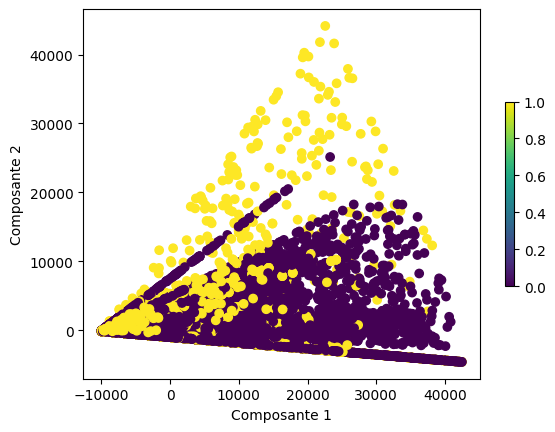

In [48]:
from mpl_toolkits.mplot3d import Axes3D
plt.ion()

# Création de la figure
fig = plt.figure()
ax = fig.add_subplot(111)

# Scatter plot 3D
scatter = ax.scatter(
    X_reduced[:, 0], 
    X_reduced[:, 1],  
    c=y, cmap='viridis', marker='o'
)

# Barre de couleur
fig.colorbar(scatter, ax=ax, shrink=0.5)

# Labels des axes
ax.set_xlabel("Composante 1")
ax.set_ylabel("Composante 2")
# ax.set_zlabel("Composante 3")

# Affichage
plt.show()

In [41]:
import pandas as pd

# Supposons que X_train est un DataFrame avec tes features extraites
# y_train la cible (0/1)

# Sélection des colonnes numériques uniquement
num_cols = df_features.select_dtypes(include=['int64', 'float64','boolean']).columns

# Calcul de corrélation
correlations = df_features[num_cols].apply(lambda col: col.corr(y))

# Affichage trié
print(correlations.abs().sort_values(ascending=False))


presence_num_ref                  0.889585
similarite_cos                    0.665956
montant_exact_match               0.546329
delai_absolu                      0.344601
ecart_montant                     0.185879
montant_ratio                     0.043170
type_operation_facture            0.028080
type_operation_depense            0.028080
categorie_divers                  0.028080
categorie_équipement              0.018011
categorie_licences_logicielles    0.017336
categorie_maintenance             0.014876
categorie_assurances              0.014275
delai_jours                       0.013771
categorie_déplacements            0.013533
montant_banque                    0.012277
categorie_services_cloud          0.008013
categorie_formations              0.007673
categorie_juridique_conformité    0.006681
categorie_frais_bancaires         0.006598
dans_fenetre_valide               0.006240
montant_operation                 0.006144
categorie_abonnements             0.005731
categorie_o

## Distribution des étiquettes

- Histogramme du nombre de transactions lettrées (`1`) et non lettrées (`0`)
- Vérification de la répartition des classes pour anticiper les déséquilibres

<BarContainer object of 2 artists>

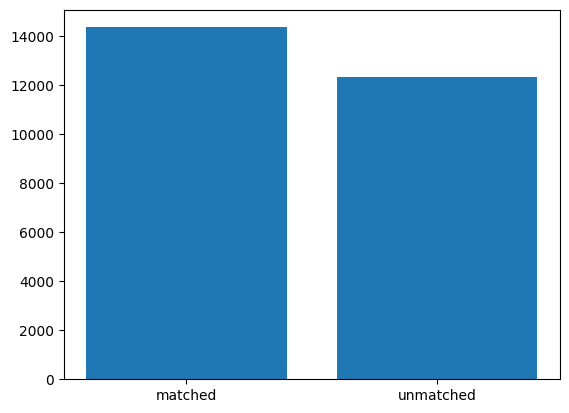

In [ ]:
x = ["matched","unmatched"]
plt.bar(x,[df_features[df_features["etiquette"] == 1]["montant_banque"].count(),df_features[df_features["etiquette"] == 0]["montant_banque"].count()])